# Data Exploration Notebook
## AI-Powered Code Security Analyzer

**Author:** Mahmut Can Dinçkuyucu (22220030094)  
**Date:** December 2024  
**Purpose:** Explore vulnerability detection dataset


## 1. Load Dataset

In [1]:
from datasets import load_from_disk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# Load the dataset
dataset = load_from_disk("C:/Users/Pc/Documents/GitHub/ai-code-security-analyzer/data/raw/sample_dataset")

print("✓ Dataset loaded successfully!")
print(f"\nAvailable splits: {list(dataset.keys())}")
print(f"Train samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

✓ Dataset loaded successfully!

Available splits: ['train', 'validation', 'test']
Train samples: 3
Validation samples: 1
Test samples: 1


## 2. Dataset Structure

In [4]:
# Check column names
print("Columns in dataset:")
print(dataset['train'].column_names)

# Show first example
print("\n" + "="*60)
print("First example structure:")
print("="*60)
example = dataset['train'][0]
for key, value in example.items():
    if key == 'func':
        print(f"{key}: [code snippet - {len(value)} characters]")
    else:
        print(f"{key}: {value}")

Columns in dataset:
['func', 'target', 'project', 'commit_id']

First example structure:
func: [code snippet - 325 characters]
target: 0
project: sample
commit_id: sample4


## 3. Convert to Pandas for Analysis

In [5]:
# Convert to pandas DataFrame
df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

print("✓ Converted to pandas DataFrames")
print(f"\nTraining set shape: {df_train.shape}")
df_train.head()

✓ Converted to pandas DataFrames

Training set shape: (3, 4)


,func,target,project,commit_id
0,"\n char* login(char* username, char...",0,sample,sample4
1,\n void read_file(char* filename) {...,1,sample,sample2
2,"\n char* login(char* username, char...",1,sample,sample1


## 4. Vulnerability Distribution

Vulnerability Distribution in Training Set:
Safe code (0): 1 samples (33.3%)
Vulnerable code (1): 2 samples (66.7%)


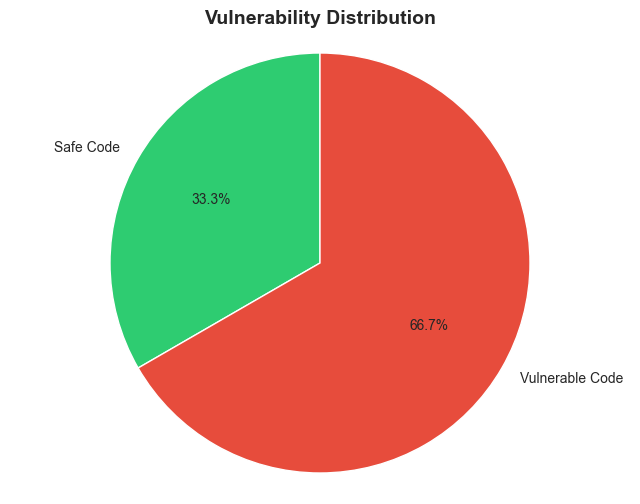

In [6]:
# Count vulnerable vs safe
print("Vulnerability Distribution in Training Set:")
print("="*60)
value_counts = df_train['target'].value_counts()
print(f"Safe code (0): {value_counts.get(0, 0)} samples ({value_counts.get(0, 0)/len(df_train)*100:.1f}%)")
print(f"Vulnerable code (1): {value_counts.get(1, 0)} samples ({value_counts.get(1, 0)/len(df_train)*100:.1f}%)")

# Visualize
plt.figure(figsize=(8, 6))
colors = ['#2ecc71', '#e74c3c']  # Green for safe, red for vulnerable
labels = ['Safe Code', 'Vulnerable Code']
sizes = [value_counts.get(0, 0), value_counts.get(1, 0)]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Vulnerability Distribution', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

## 5. Code Length Analysis

Code Length Statistics:
        count   mean       std    min     25%    50%     75%    max
target                                                             
0         1.0  325.0       NaN  325.0  325.00  325.0  325.00  325.0
1         2.0  260.5  21.92031  245.0  252.75  260.5  268.25  276.0


<Figure size 1000x600 with 0 Axes>

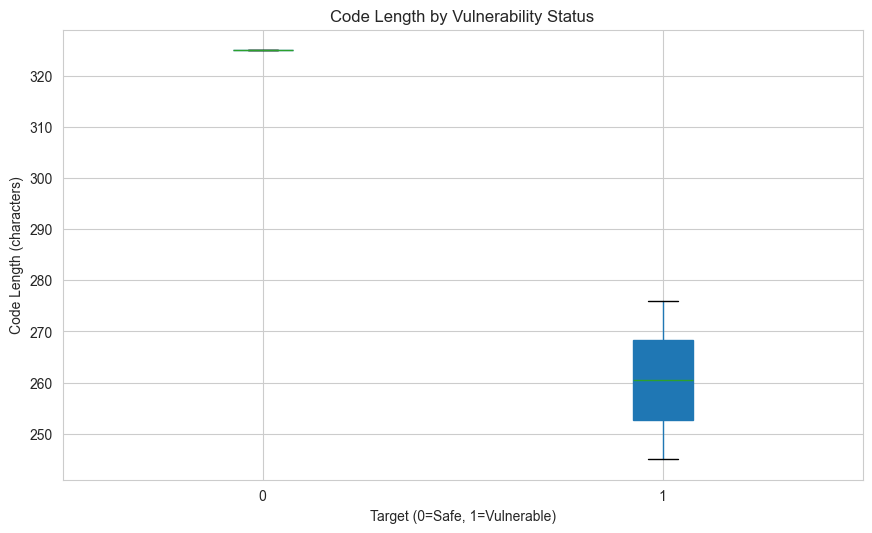

In [7]:
# Add code length column
df_train['code_length'] = df_train['func'].str.len()

# Statistics
print("Code Length Statistics:")
print("="*60)
print(df_train.groupby('target')['code_length'].describe())

# Visualize
plt.figure(figsize=(10, 6))
df_train.boxplot(column='code_length', by='target', patch_artist=True)
plt.title('Code Length by Vulnerability Status')
plt.suptitle('')  # Remove default title
plt.xlabel('Target (0=Safe, 1=Vulnerable)')
plt.ylabel('Code Length (characters)')
plt.show()

## 6. Example Vulnerable Code

In [8]:
# Show all vulnerable examples
vulnerable_samples = df_train[df_train['target'] == 1]

print(f"Found {len(vulnerable_samples)} vulnerable code samples\n")
print("="*60)

for idx, row in vulnerable_samples.iterrows():
    print(f"\nVULNERABLE EXAMPLE #{idx + 1}:")
    print("-" * 60)
    print(row['func'])
    print("-" * 60)
    print(f"Project: {row['project']}")
    print(f"Commit ID: {row['commit_id']}")
    print()

Found 2 vulnerable code samples


VULNERABLE EXAMPLE #2:
------------------------------------------------------------

            void read_file(char* filename) {
                char buffer[100];
                FILE* f = fopen(filename, "r");
                gets(buffer);  // Buffer overflow vulnerability
                fclose(f);
            }
            
------------------------------------------------------------
Project: sample
Commit ID: sample2


VULNERABLE EXAMPLE #3:
------------------------------------------------------------

            char* login(char* username, char* password) {
                char query[256];
                sprintf(query, "SELECT * FROM users WHERE username='%s' AND password='%s'", username, password);
                return execute_query(query);
            }
            
------------------------------------------------------------
Project: sample
Commit ID: sample1



## 7. Example Safe Code

In [9]:
# Show all safe examples
safe_samples = df_train[df_train['target'] == 0]

print(f"Found {len(safe_samples)} safe code samples\n")
print("="*60)

for idx, row in safe_samples.iterrows():
    print(f"\nSAFE EXAMPLE #{idx + 1}:")
    print("-" * 60)
    print(row['func'])
    print("-" * 60)
    print(f"Project: {row['project']}")
    print(f"Commit ID: {row['commit_id']}")
    print()

Found 1 safe code samples


SAFE EXAMPLE #1:
------------------------------------------------------------

            char* login(char* username, char* password) {
                PreparedStatement* stmt = prepare("SELECT * FROM users WHERE username=? AND password=?");
                bind_string(stmt, 1, username);
                bind_string(stmt, 2, password);
                return execute(stmt);
            }
            
------------------------------------------------------------
Project: sample
Commit ID: sample4



## 8. Identify Vulnerability Patterns

In [10]:
import re

# Define patterns for common vulnerabilities
vulnerability_patterns = {
    'SQL Injection': r'(sprintf|strcat|strcpy).*SELECT.*WHERE',
    'Buffer Overflow': r'(gets|strcpy|sprintf)\s*\(',
    'Command Injection': r'(system|exec|popen)\s*\(',
    'Format String': r'printf\s*\([^"]*%',
    'Hardcoded Credentials': r'(password|api_key|secret)\s*=\s*["\']',
}

# Check each vulnerable sample
print("Vulnerability Pattern Analysis:")
print("="*60)

for idx, row in vulnerable_samples.iterrows():
    code = row['func']
    print(f"\nSample #{idx + 1}:")
    found_patterns = []
    
    for vuln_type, pattern in vulnerability_patterns.items():
        if re.search(pattern, code, re.IGNORECASE):
            found_patterns.append(vuln_type)
    
    if found_patterns:
        print(f"  Detected: {', '.join(found_patterns)}")
    else:
        print(f"  No specific pattern detected (may need manual analysis)")

Vulnerability Pattern Analysis:

Sample #2:
  Detected: Buffer Overflow

Sample #3:
  Detected: SQL Injection, Buffer Overflow, Hardcoded Credentials


## 9. Dataset Summary

In [11]:
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"\nTotal samples: {len(df_train) + len(df_val) + len(df_test)}")
print(f"  - Training: {len(df_train)}")
print(f"  - Validation: {len(df_val)}")
print(f"  - Test: {len(df_test)}")
print(f"\nVulnerable samples: {df_train['target'].sum()}")
print(f"Safe samples: {len(df_train) - df_train['target'].sum()}")
print(f"\nAverage code length: {df_train['code_length'].mean():.0f} characters")
print(f"Min code length: {df_train['code_length'].min()} characters")
print(f"Max code length: {df_train['code_length'].max()} characters")

print("\n" + "="*60)
print("NOTE: This is a SAMPLE dataset for testing!")
print("For actual training, you'll need the full Devign dataset")
print("with ~27,000 samples.")
print("="*60)


DATASET SUMMARY

Total samples: 5
  - Training: 3
  - Validation: 1
  - Test: 1

Vulnerable samples: 2
Safe samples: 1

Average code length: 282 characters
Min code length: 245 characters
Max code length: 325 characters

NOTE: This is a SAMPLE dataset for testing!
For actual training, you'll need the full Devign dataset
with ~27,000 samples.


## 10. Next Steps

### ✅ What we learned:
1. Dataset has labeled vulnerable and safe code
2. We can identify some vulnerability patterns
3. Code samples vary in length
4. Data is structured for training

### 📝 TODO:
1. Create preprocessing pipeline
2. Test tokenization with CodeBERT
3. Build simple classifier
4. Get full dataset for actual training

## 11. Save Insights

In [13]:
import os

# Create processed directory if it doesn't exist
os.makedirs('data/processed', exist_ok=True)

# Now save summary to file
with open('data/processed/dataset_summary.txt', 'w') as f:
    f.write("Dataset Exploration Summary\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Total samples: {len(df_train) + len(df_val) + len(df_test)}\n")
    f.write(f"Training: {len(df_train)}\n")
    f.write(f"Validation: {len(df_val)}\n")
    f.write(f"Test: {len(df_test)}\n\n")
    f.write(f"Vulnerable: {df_train['target'].sum()}\n")
    f.write(f"Safe: {len(df_train) - df_train['target'].sum()}\n\n")
    f.write("\nNote: Sample dataset for development/testing only\n")

print("✓ Summary saved to: data/processed/dataset_summary.txt")

✓ Summary saved to: data/processed/dataset_summary.txt
